# Import package and Data

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil


import tempfile
from keras.utils import np_utils

from  IPython import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

!pip install -q tf-models-official

import os
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

     |████████████████████████████████| 4.4 MB 5.4 MB/s 
     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 213 kB 49.0 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 1.2 MB 32.8 MB/s 
     |████████████████████████████████| 37.1 MB 45 kB/s 
     |████████████████████████████████| 596 kB 47.0 MB/s 
     |████████████████████████████████| 352 kB 48.0 MB/s 
     |████████████████████████████████| 99 kB 8.5 MB/s 


In [3]:
#Read file from drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
twitter_raw = pd.read_csv("drive/My Drive/Rumour_data/twitter_dataset.csv")
reddit_raw = pd.read_csv("drive/My Drive/Rumour_data/Extra_reddit_dataset.csv")

In [5]:
twitter_raw

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.810630e+17,-1.000000e+00,#4U9525: Robin names Andreas Lubitz as the cop...,germanwings-crash,-1
1,Reply,5.810700e+17,5.810630e+17,@thatjohn Have they named the pilot?,germanwings-crash,query
2,Reply,5.810640e+17,5.810630e+17,@thatjohn @mschenk,germanwings-crash,comment
3,Source,5.813860e+17,-1.000000e+00,RT @khjelmgaard: German media reporting #Andre...,germanwings-crash,-1
4,Reply,5.815760e+17,5.813860e+17,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,germanwings-crash,comment
...,...,...,...,...,...,...
6629,Reply,9.042010e+17,9.042000e+17,@verge https://t.co/sRsBbWzZku,fire-ants,comment
6630,Reply,9.042080e+17,9.042000e+17,@verge take a piss on them,fire-ants,comment
6631,Reply,9.042010e+17,9.042000e+17,@verge flamethrower them,fire-ants,comment
6632,Reply,9.044060e+17,9.042000e+17,@verge First of all: Be Impressed!,fire-ants,comment


# Data Exploration

In [6]:
twitter_raw.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.810630e+17,-1.000000e+00,#4U9525: Robin names Andreas Lubitz as the cop...,germanwings-crash,-1
1,Reply,5.810700e+17,5.810630e+17,@thatjohn Have they named the pilot?,germanwings-crash,query
2,Reply,5.810640e+17,5.810630e+17,@thatjohn @mschenk,germanwings-crash,comment
3,Source,5.813860e+17,-1.000000e+00,RT @khjelmgaard: German media reporting #Andre...,germanwings-crash,-1
4,Reply,5.815760e+17,5.813860e+17,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,germanwings-crash,comment


In [7]:
twitter_raw['Class'].value_counts()

comment    4445
support     792
query       520
deny        496
-1          381
Name: Class, dtype: int64

In [8]:
4445/(4445+792+520+496)

0.7108587877818647

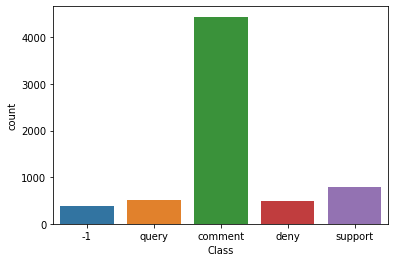

In [10]:
sns.countplot(x="Class", data=twitter_raw)

* Twitter data have 381 source tweets. 
* The class is server imbalance. Comment class account for 71% of all classes, support 12.7%, query 8.3% and deny 7.9%.

In [11]:
twitter_raw['text_len'] = twitter_raw['Text'].astype(str).map(len)

In [12]:
twitter_raw.groupby('Class', as_index=False).agg({"text_len": np.mean})

,Class,text_len
0,-1,119.792651
1,comment,89.810574
2,deny,94.143145
3,query,84.496154
4,support,99.694444


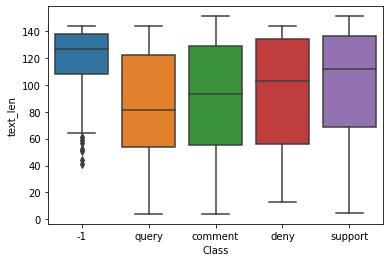

In [13]:
sns.boxplot(x="Class", y="text_len", data=twitter_raw)

* Source tweet have significant longer than other type of tweet. 


In [14]:
reddit_raw.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,63uefi,-1,Donald Trump's travel expenses in 10 weeks cos...,None,-1
1,Reply,dfx7l1a,63uefi,But he was from 2001-2009? I don't get what di...,None,comment
2,Reply,dfx88qg,63uefi,Cheney resigned as CEO of Halliburton on July ...,None,comment
3,Reply,dfx3i17,63uefi,[deleted],None,comment
4,Reply,dfx4yef,63uefi,"That is literally not a source, that is Niamh ...",None,comment


* Reddit reply got deleted.

In [15]:
reddit_raw[reddit_raw['Text'] == '[deleted]'].count()

Type             119
Msg_ID           119
Source_Msg_ID    119
Text             119
Topic            119
Class            119
dtype: int64

In [9]:
reddit_clean = reddit_raw.drop(reddit_raw[reddit_raw['Text'] == '[deleted]'].index).reset_index().drop('index',axis = 1)

In [10]:
reddit_clean.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,63uefi,-1,Donald Trump's travel expenses in 10 weeks cos...,None,-1
1,Reply,dfx7l1a,63uefi,But he was from 2001-2009? I don't get what di...,None,comment
2,Reply,dfx88qg,63uefi,Cheney resigned as CEO of Halliburton on July ...,None,comment
3,Reply,dfx4yef,63uefi,"That is literally not a source, that is Niamh ...",None,comment
4,Reply,dfx8wwi,63uefi,"Nope, she cites actual statistics.",None,comment


In [18]:
reddit_clean['Class'].value_counts()

comment    2137
deny         89
query        63
-1           40
support      23
Name: Class, dtype: int64

In [19]:
23/(2137+89+63+23)

0.009948096885813149

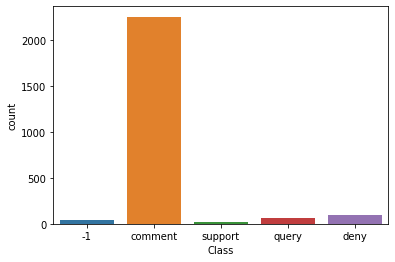

In [20]:
sns.countplot(x="Class", data=reddit_raw)

* Reddit data have 40 source msgs. 
* Reddit data have more server class imbalance than twitter data.
* Comment class contribute 92.4%, deny 3.8%, query 2.7% and support 1%

# Preprocess


In [5]:
!pip install tweet-preprocessor
!pip install unidecode
!pip install emoji

     |████████████████████████████████| 235 kB 5.2 MB/s 
     |████████████████████████████████| 170 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=0f482a6ecf81be5d4762d7cab45cf25cd98557436f1efcaaba25dece5e5993e5
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [6]:
import preprocessor as p
import spacy
from spacy.symbols import  ORTH
import unidecode
import emoji

nlp = spacy.load("en")
nlp.add_pipe(nlp.create_pipe('sentencizer'))
for x in ['URL', 'MENTION', 'HASHTAG', 'RESERVED', 'EMOJI', 'SMILEY', 'NUMBER', ]:
    nlp.tokenizer.add_special_case(f'${x}$', [{ORTH: f'${x}$'}])

def preprocess(df):
  new_df = df.copy()
  p.set_options(p.OPT.URL, p.OPT.MENTION)
  #token menton to $MENTION$ and url to $URL$ as BUT-FIT paper
  #convert emoji in to word
  new_df['Text_tokenize'] = new_df['Text'].apply(lambda x: emoji.demojize(p.tokenize(x),language='en'))

  return new_df

In [13]:
twitter_raw2 = preprocess(twitter_raw)
reddit_raw2 = preprocess(reddit_clean)

In [14]:
twitter_raw2[twitter_raw2['Msg_ID']==5.80338E+17]

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,Text_tokenize
94,Reply,5.803380e+17,5.803190e+17,"@LoveNotH81 @verylastone Yes, it is. 😰 Sounds ...",germanwings-crash,comment,"$MENTION$ $MENTION$ Yes, it is. :anxious_face_..."
97,Reply,5.803380e+17,5.803190e+17,. @LoveNotH81 @dorome80 Just heard: No survivo...,germanwings-crash,comment,. $MENTION$ $MENTION$ Just heard: No survivors...
111,Reply,5.803380e+17,5.803190e+17,@verylastone @dorome80 my heart is with the lo...,germanwings-crash,comment,$MENTION$ $MENTION$ my heart is with the loved...
359,Reply,5.803380e+17,5.803340e+17,@BBCBreaking so called experts say no time for...,germanwings-crash,comment,$MENTION$ so called experts say no time for di...
371,Reply,5.803380e+17,5.803340e+17,@BBCBreaking On a positive note there is a run...,germanwings-crash,comment,$MENTION$ On a positive note there is a runway...


In [15]:
twitter_raw2['Text'][94]

'@LoveNotH81 @verylastone Yes, it is. 😰 Sounds like there are no survivors.'

In [16]:
twitter_raw2['Text_tokenize'][94]

'$MENTION$ $MENTION$ Yes, it is. :anxious_face_with_sweat: Sounds like there are no survivors.'

In [15]:
def concat_source_to_reply(table):
  source_index = []
  df=pd.DataFrame()
  for index, row in table.iterrows():
    if(row['Type'] == "Source"):
      source_index.append(index)

  list_index = []
  for i in range(len(source_index)):
    if i < len(source_index)-1:
      list_index.append([source_index[i],source_index[i+1]-1])
    else:
      list_index.append([source_index[i],len(table)-1])

  df_list=[]
  for i in list_index:
    df_list.append(table.loc[i[0]:i[1]].reset_index().drop('index',axis=1))
    
  for i in range(len(df_list)):
    # lower case and stripped accent markers as BERT preprocess require https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
    df_list[i]['Text_tokenize'] = df_list[i]['Text_tokenize'].apply(lambda x: unidecode.unidecode(x.lower())).astype(str)
    source_text = df_list[i].iloc[0]['Text_tokenize']

    #df_list[i]['input_text'] = "[CLS] "+source_text+" [SEP] "+ df_list[i]['Text_tokenize']+" [SEP]"
    df_list[i]['source_text'] = source_text

  final_df_temp = pd.concat(df_list, ignore_index=True)
  final_df = final_df_temp[final_df_temp['Type']=='Reply'].copy().reset_index().drop('index',axis = 1)

  return final_df

#### Match source and reply

In [18]:
# match source tweet and reply
twitter_final = concat_source_to_reply(twitter_raw2)
reddit_final = concat_source_to_reply(reddit_raw2)

In [19]:
twitter_final.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,Text_tokenize,source_text
0,Reply,5.810700e+17,5.810630e+17,@thatjohn Have they named the pilot?,germanwings-crash,query,$mention$ have they named the pilot?,#4u9525: robin names andreas lubitz as the cop...
1,Reply,5.810640e+17,5.810630e+17,@thatjohn @mschenk,germanwings-crash,comment,$mention$ $mention$,#4u9525: robin names andreas lubitz as the cop...
2,Reply,5.815760e+17,5.813860e+17,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,germanwings-crash,comment,$mention$ $mention$ $mention$ #f4phantom #cras...,rt $mention$: german media reporting #andreasl...
3,Reply,5.820480e+17,5.813860e+17,@USATODAY @khjelmgaard ers a link to prove @An...,germanwings-crash,comment,$mention$ $mention$ ers a link to prove $menti...,rt $mention$: german media reporting #andreasl...
4,Reply,5.822060e+17,5.813860e+17,@USATODAY @khjelmgaard Sure #GermanWings CoPil...,germanwings-crash,comment,$mention$ $mention$ sure #germanwings copilot ...,rt $mention$: german media reporting #andreasl...


#### Encode class

In [20]:
#Encode 
encode = {
    "query" : 0,
    "comment"  : 1,       
    "deny" : 2,    
    "support" : 3
}

twitter_final["predicted_Class"] = twitter_final["Class"].apply(lambda x: encode[x])
reddit_final["predicted_Class"] = reddit_final["Class"].apply(lambda x: encode[x])

# Train-Test split

* For prevent data leakage, twitter data will be split by topic and Reddit data will split by source msg.

In [21]:
import random

In [22]:
topic_twitter= twitter_raw['Topic'].unique()

In [23]:
len(topic_twitter)

37

In [24]:
random.seed(7) 
random.shuffle(topic_twitter)

In [25]:
train_topic = topic_twitter[:26]
val_topic = topic_twitter[26:32]
test_topic = topic_twitter[32:]
twitter_train_df = twitter_final[twitter_final['Topic'].isin(train_topic)].reset_index().drop('index',axis =1)
twitter_val_df = twitter_final[twitter_final['Topic'].isin(val_topic)].reset_index().drop('index',axis =1)
twitter_test_df = twitter_final[twitter_final['Topic'].isin(test_topic)].reset_index().drop('index',axis =1)

In [26]:
#twitter_train_df['Class'].value_counts(normalize=True)
twitter_train_df['Class'].value_counts()

comment    2364
support     463
query       260
deny        243
Name: Class, dtype: int64

In [27]:
#twitter_val_df['Class'].value_counts(normalize=True)
twitter_val_df['Class'].value_counts()

comment    1055
support     181
query       138
deny        120
Name: Class, dtype: int64

In [28]:
#twitter_test_df['Class'].value_counts(normalize=True)
twitter_test_df['Class'].value_counts()

comment    1026
support     148
deny        133
query       122
Name: Class, dtype: int64

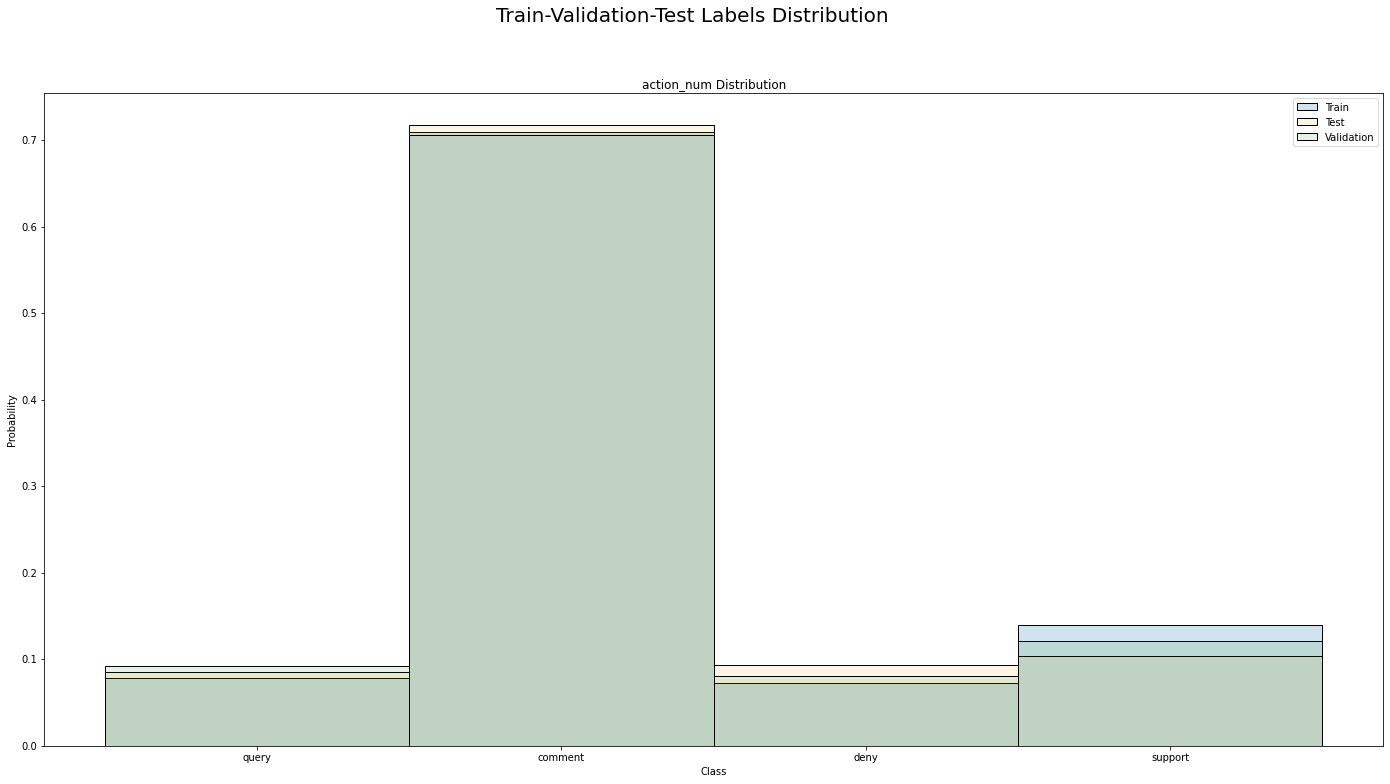

In [39]:
fig, ax1= plt.subplots(figsize=(24,12))

sns.histplot(data=twitter_train_df, x='Class', stat='probability', alpha=0.2, ax=ax1, label='Train',bins=21)
sns.histplot(data=twitter_test_df, x='Class', stat='probability', alpha=0.1, color='orange', ax=ax1, label='Test',bins=21)
sns.histplot(data=twitter_val_df, x='Class', stat='probability', alpha=0.1, color='green', ax=ax1, label='Validation',bins=21)
ax1.set_title('action_num Distribution')
ax1.legend()

fig.suptitle("Train-Validation-Test Labels Distribution", size=20)
fig.show()

In [40]:
train_x_text_tweet = twitter_train_df['Text_tokenize'].values.tolist()
train_source_tweet = twitter_train_df['source_text'].values.tolist()
train_y_encode = twitter_train_df['predicted_Class'].values.tolist()
train_y_tweet =  np_utils.to_categorical(train_y_encode)

In [41]:
val_x_text_tweet = twitter_val_df['Text_tokenize'].values.tolist()
val_source_tweet = twitter_val_df['source_text'].values.tolist()
val_y_encode = twitter_val_df['predicted_Class'].values.tolist()
val_y_tweet =  np_utils.to_categorical(val_y_encode)

In [42]:
test_x_text_tweet = twitter_test_df['Text_tokenize'].values.tolist()
test_source_tweet = twitter_test_df['source_text'].values.tolist()
test_y_encode = twitter_test_df['predicted_Class'].values.tolist()
test_y_tweet =  np_utils.to_categorical(test_y_encode)

In [43]:
x_train_np = np.array(train_x_text_tweet)
x_source_np = np.array(train_source_tweet)
x_val_np = np.array(val_x_text_tweet)
x_val_source_np = np.array(val_source_tweet)
x_test_np = np.array(test_x_text_tweet)
x_test_source_np = np.array(test_source_tweet)

In [44]:
reddit_tweet_train = pd.concat([twitter_train_df,reddit_final],ignore_index=True)

In [45]:
reddit_x = reddit_tweet_train['Text_tokenize'].values.tolist()
source_reddit = reddit_tweet_train['source_text'].values.tolist()
y_encode = reddit_tweet_train['predicted_Class'].values.tolist()
y_reddit =  np_utils.to_categorical(y_encode)

In [46]:
x_reddit_np = np.array(reddit_x)
x_reddit_source_np = np.array(source_reddit)

# Model

## Preprocess model

In [25]:
def bert_preprocess_model(sentence_features, seq_length=128):

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]
  
  #customize length
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [48]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
test_preprocess_model = bert_preprocess_model(['Source', 'Reply'])

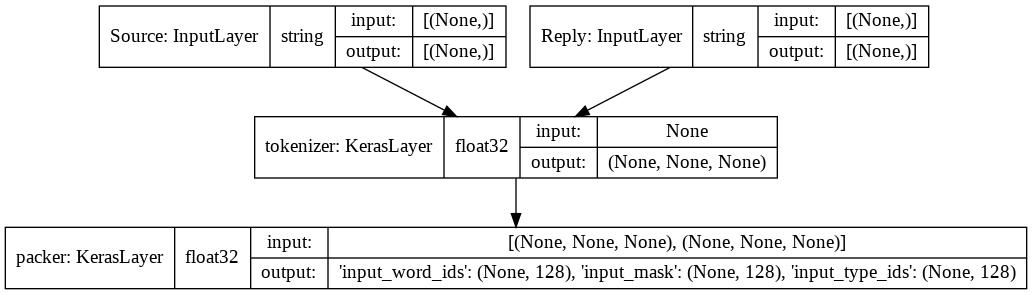

In [49]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

In [50]:
twitter_train_df['Text_tokenize'][0]

'$mention$ have they named the pilot?'

In [51]:
twitter_train_df['source_text'][0]

'#4u9525: robin names andreas lubitz as the copilot in the flight deck who crashed the aircraft.'

In [76]:
[x_source_np[0],x_train_np[0]]

['#4u9525: robin names andreas lubitz as the copilot in the flight deck who crashed the aircraft.',
 '$mention$ have they named the pilot?']

In [85]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
source_t = bert_preprocess.tokenize(tf.constant([x_source_np[0]]))
reply_t =  bert_preprocess.tokenize(tf.constant([x_train_np[0]]))

In [87]:
[x_source_np[0],x_train_np[0]]

['#4u9525: robin names andreas lubitz as the copilot in the flight deck who crashed the aircraft.',
 '$mention$ have they named the pilot?']

In [92]:
text_preprocessed = bert_preprocess.bert_pack_inputs([source_t,reply_t], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :20])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :20])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :20])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  1001  1018  2226  2683 25746  2629  1024  5863  3415   102  1002
  5254  1002  2031  2027  2315  1996  4405   102], shape=(20,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(20,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1], shape=(20,), dtype=int32)


## Utility function

In [26]:
def build_classifier_model_1layer(dropout = 0.1,dense = 512,trainable = True):
  preprocessor = bert_preprocess_model(['Source', 'Reply'])
  text_preprocessed = preprocessor.output
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=trainable, name='BERT_encoder')
  outputs = encoder(text_preprocessed)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(dense, activation='tanh', name='dense2')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
  return tf.keras.Model(preprocessor.input, net)

In [27]:
from keras.callbacks import ModelCheckpoint
def get_callbacks(name):
  checkpoint = './drive/My Drive/training_checkpoints'
  #checkpoint_filepath = os.path.join(checkpoint, "checkpoint_{epoch:02d}")
  checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_{epoch:02d}")
  model_checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            save_best_only=False)
  return model_checkpoint_callback

In [28]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tfa.metrics.F1Score(num_classes=4,average='macro')
class_weight = {0: 3.201923076923077,
                1: 0.35215736040609136,
                2: 3.425925925925926,
                3: 1.7980561555075596}

In [29]:
#For plot train-validation loss and f1 score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
def plot_validation_performance(history, recall_num=''):
    history_frame = pd.DataFrame(history.history)
    fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(10,4))

    history_frame.loc[:, ['loss', 'val_loss']].plot(ax = ax1)
    history_frame.loc[:, ['f1_score', 'val_f1_score']].plot(ax = ax2)

    ax1.set_title("Categorical Entrophy", size=14)
    ax2.set_title("macro f1_score", size=14)

    fig.suptitle("Train-Validation Performance Comparison", size=18, y= 1.05)

    fig.show()

def performance_class(model,X,y,class_list):
  pred = model.predict(X)
  #action_pred = np.argmax(y[0],axis=1)
  class_pred = np.argmax(pred,axis=1)

  #action_true = test_generator.action
  class_true = np.argmax(y,axis=1)

  print(classification_report(class_true, class_pred))

  #action_names = action_list
  class_name = class_list

  disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(class_true, class_pred,normalize = 'true'), 
                                  display_labels=list(class_name))

  disp.plot()

# BERT LARGE uncase 1024

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-24_H-1024_A-16'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder,' (tfhub_handle_encoder)')
print('Preprocessing model auto-selected:', tfhub_handle_preprocess,' (tfhub_handle_preprocess)')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4  (tfhub_handle_encoder)
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3  (tfhub_handle_preprocess)


In [ ]:
BERT_LARGE_train = build_classifier_model_1layer(dense = 1024)

In [ ]:
batch_size = 8
epochs = 5
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_LARGE_train.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = BERT_LARGE_train.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=4,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_large_2Input_trainable')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4
Epoch 1/5
833/833 [==============================] - 870s 998ms/step - loss: 1.8244 - f1_score: 0.2410 - val_loss: 1.7962 - val_f1_score: 0.0372
Epoch 2/5
833/833 [==============================] - 830s 997ms/step - loss: 1.6269 - f1_score: 0.2392 - val_loss: 1.2889 - val_f1_score: 0.0540
Epoch 3/5
833/833 [==============================] - 832s 998ms/step - loss: 1.5539 - f1_score: 0.2615 - val_loss: 1.2578 - val_f1_score: 0.2069
Epoch 4/5
833/833 [==============================] - 887s 1s/step - loss: 1.5905 - f1_score: 0.2336 - val_loss: 1.2578 - val_f1_score: 0.2069
Epoch 5/5
833/833 [==============================] - 833s 1000ms/step - loss: 1.5770 - f1_score: 0.2457 - val_loss: 1.2578 - val_f1_score: 0.2069


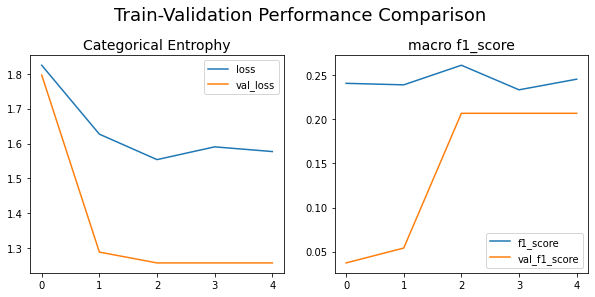

In [ ]:
plot_validation_performance(history)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.71      1.00      0.83      1055
           2       0.00      0.00      0.00       120
           3       0.00      0.00      0.00       181

    accuracy                           0.71      1494
   macro avg       0.18      0.25      0.21      1494
weighted avg       0.50      0.71      0.58      1494



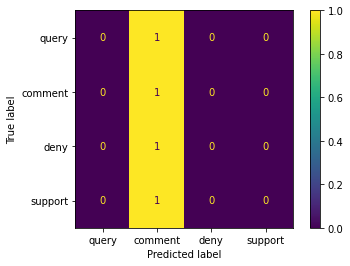

In [ ]:
performance_class(BERT_LARGE_train,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

#BERT base 768

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder,' (tfhub_handle_encoder)')
print('Preprocessing model auto-selected:', tfhub_handle_preprocess,' (tfhub_handle_preprocess)')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3  (tfhub_handle_encoder)
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3  (tfhub_handle_preprocess)


In [104]:
BERT_base_train = build_classifier_model_1layer(dense = 768)

In [ ]:
batch_size = 8
epochs = 20
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_train.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history2 = BERT_base_train.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_trainable')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/20
417/417 [==============================] - 252s 577ms/step - loss: 1.3680 - f1_score: 0.2988 - val_loss: 0.9258 - val_f1_score: 0.4158
Epoch 2/20
417/417 [==============================] - 240s 575ms/step - loss: 1.1702 - f1_score: 0.4788 - val_loss: 1.0958 - val_f1_score: 0.4102
Epoch 3/20
417/417 [==============================] - 240s 576ms/step - loss: 0.9827 - f1_score: 0.5845 - val_loss: 1.1077 - val_f1_score: 0.4215
Epoch 4/20
417/417 [==============================] - 240s 576ms/step - loss: 0.6716 - f1_score: 0.7613 - val_loss: 1.2319 - val_f1_score: 0.4517
Epoch 5/20
417/417 [==============================] - 240s 575ms/step - loss: 0.4768 - f1_score: 0.8442 - val_loss: 1.6360 - val_f1_score: 0.4334
Epoch 6/20
417/417 [==============================] - 240s 576ms/step - loss: 0.3181 - f1_score: 0.9031 - val_loss: 2.2466 - val_f1_score: 0.4165
Epoch 7/20
417/417 [=====================

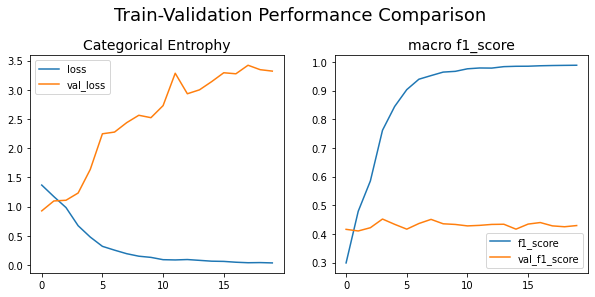

In [ ]:
plot_validation_performance(history2)

              precision    recall  f1-score   support

           0       0.49      0.44      0.46       138
           1       0.77      0.81      0.79      1055
           2       0.30      0.26      0.28       120
           3       0.30      0.26      0.28       181

    accuracy                           0.66      1494
   macro avg       0.46      0.44      0.45      1494
weighted avg       0.65      0.66      0.65      1494



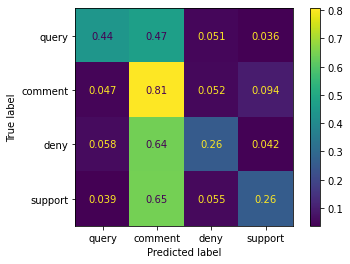

In [107]:
name = 'models/BERT_base_2Input_trainable'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_base_train.load_weights(checkpoint_filepath)
performance_class(BERT_base_train,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

              precision    recall  f1-score   support

           0       0.61      0.46      0.52       122
           1       0.79      0.85      0.82      1026
           2       0.39      0.22      0.28       133
           3       0.30      0.30      0.30       148

    accuracy                           0.70      1429
   macro avg       0.52      0.46      0.48      1429
weighted avg       0.68      0.70      0.69      1429



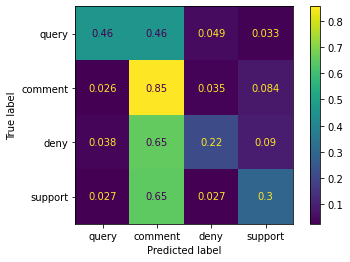

In [106]:
name = 'models/BERT_base_2Input_trainable'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_base_train.load_weights(checkpoint_filepath)
performance_class(BERT_base_train,[x_test_source_np,x_test_np],test_y_tweet, ["query","comment","deny","support"] )

### 0.5 dropout (Best dropout)

In [ ]:
BERT_base_train_drop05 = build_classifier_model_1layer(dropout = 0.5,dense = 768)

In [ ]:
batch_size = 8
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_train_drop05.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history3 = BERT_base_train_drop05.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_trainable_05')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
417/417 [==============================] - 266s 586ms/step - loss: 1.4999 - f1_score: 0.2820 - val_loss: 1.2880 - val_f1_score: 0.3918
Epoch 2/10
417/417 [==============================] - 245s 588ms/step - loss: 1.2011 - f1_score: 0.4620 - val_loss: 1.1841 - val_f1_score: 0.4522
Epoch 3/10
417/417 [==============================] - 244s 586ms/step - loss: 1.0075 - f1_score: 0.5914 - val_loss: 1.3317 - val_f1_score: 0.4460
Epoch 4/10
417/417 [==============================] - 244s 584ms/step - loss: 0.7456 - f1_score: 0.7358 - val_loss: 1.2175 - val_f1_score: 0.4685
Epoch 5/10
417/417 [==============================] - 245s 587ms/step - loss: 0.4814 - f1_score: 0.8603 - val_loss: 1.9500 - val_f1_score: 0.4508
Epoch 6/10
417/417 [==============================] - 244s 584ms/step - loss: 0.3362 - f1_score: 0.9170 - val_loss: 1.9418 - val_f1_score: 0.4235
Epoch 7/10
417/417 [=====================

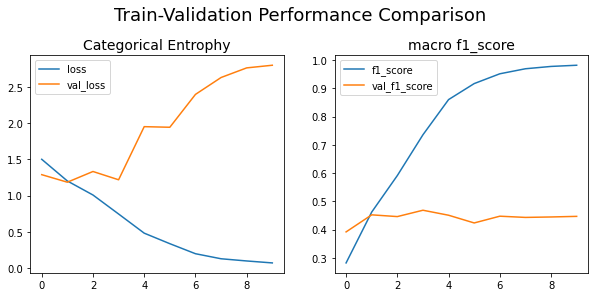

In [ ]:
plot_validation_performance(history3)

              precision    recall  f1-score   support

           0       0.56      0.45      0.50       138
           1       0.77      0.86      0.81      1055
           2       0.34      0.28      0.31       120
           3       0.35      0.20      0.25       181

    accuracy                           0.70      1494
   macro avg       0.50      0.45      0.47      1494
weighted avg       0.67      0.70      0.68      1494



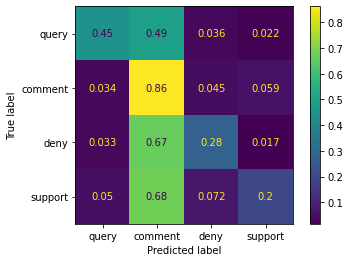

In [ ]:
name = 'models/BERT_base_2Input_trainable_05'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_base_train_drop05.load_weights(checkpoint_filepath)
performance_class(BERT_base_train_drop05,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

              precision    recall  f1-score   support

           0       0.63      0.52      0.57       122
           1       0.78      0.88      0.83      1026
           2       0.37      0.20      0.26       133
           3       0.32      0.22      0.26       148

    accuracy                           0.72      1429
   macro avg       0.53      0.45      0.48      1429
weighted avg       0.68      0.72      0.69      1429



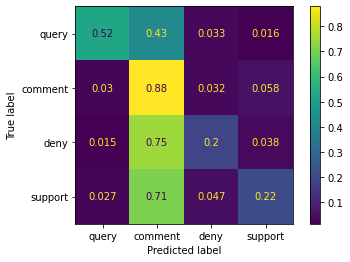

In [ ]:
name = 'models/BERT_base_2Input_trainable_05'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_base_train_drop05.load_weights(checkpoint_filepath)
performance_class(BERT_base_train_drop05,[x_test_source_np,x_test_np],test_y_tweet, ["query","comment","deny","support"] )

## 0.7 Dropout

In [ ]:
BERT_base_train_drop07 = build_classifier_model_1layer(dropout = 0.7,dense = 768)

In [ ]:
batch_size = 8
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_train_drop07.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history4 = BERT_base_train_drop07.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_trainable_07')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
417/417 [==============================] - 263s 586ms/step - loss: 1.5843 - f1_score: 0.3230 - val_loss: 1.2144 - val_f1_score: 0.2590
Epoch 2/10
417/417 [==============================] - 245s 586ms/step - loss: 1.3567 - f1_score: 0.4013 - val_loss: 0.9939 - val_f1_score: 0.4276
Epoch 3/10
417/417 [==============================] - 244s 585ms/step - loss: 1.1338 - f1_score: 0.5200 - val_loss: 1.0700 - val_f1_score: 0.4505
Epoch 4/10
417/417 [==============================] - 244s 585ms/step - loss: 0.8304 - f1_score: 0.6745 - val_loss: 1.4321 - val_f1_score: 0.4300
Epoch 5/10
417/417 [==============================] - 244s 586ms/step - loss: 0.5493 - f1_score: 0.8001 - val_loss: 1.3698 - val_f1_score: 0.4390
Epoch 6/10
417/417 [==============================] - 245s 586ms/step - loss: 0.3280 - f1_score: 0.9053 - val_loss: 2.2514 - val_f1_score: 0.4347
Epoch 7/10
417/417 [=====================

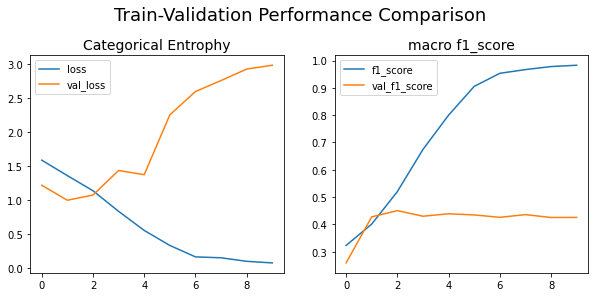

In [ ]:
plot_validation_performance(history4)

              precision    recall  f1-score   support

           0       0.37      0.68      0.48       138
           1       0.81      0.69      0.74      1055
           2       0.23      0.33      0.27       120
           3       0.31      0.30      0.30       181

    accuracy                           0.61      1494
   macro avg       0.43      0.50      0.45      1494
weighted avg       0.66      0.61      0.63      1494



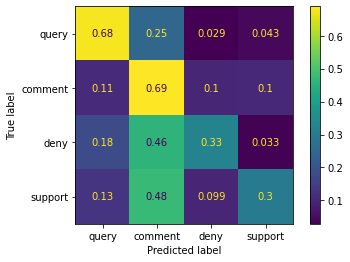

In [ ]:
name = 'models/BERT_base_2Input_trainable_07'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_03")
BERT_base_train_drop07.load_weights(checkpoint_filepath)
performance_class(BERT_base_train_drop07,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

## 0.3 DROPOUT

In [ ]:
BERT_base_train_drop03 = build_classifier_model_1layer(dropout = 0.3,dense = 768)

In [ ]:
batch_size = 8
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_train_drop03.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history5 = BERT_base_train_drop03.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_trainable_03')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
417/417 [==============================] - 272s 602ms/step - loss: 1.4708 - f1_score: 0.2815 - val_loss: 1.0664 - val_f1_score: 0.3860
Epoch 2/10
417/417 [==============================] - 252s 605ms/step - loss: 1.2279 - f1_score: 0.4669 - val_loss: 1.0599 - val_f1_score: 0.4421
Epoch 3/10
417/417 [==============================] - 252s 605ms/step - loss: 0.9575 - f1_score: 0.6194 - val_loss: 0.9993 - val_f1_score: 0.4626
Epoch 4/10
417/417 [==============================] - 252s 604ms/step - loss: 0.6548 - f1_score: 0.7610 - val_loss: 1.2433 - val_f1_score: 0.4389
Epoch 5/10
417/417 [==============================] - 253s 606ms/step - loss: 0.3930 - f1_score: 0.8790 - val_loss: 1.8240 - val_f1_score: 0.4608
Epoch 6/10
417/417 [==============================] - 253s 606ms/step - loss: 0.2455 - f1_score: 0.9336 - val_loss: 2.3161 - val_f1_score: 0.4559
Epoch 7/10
417/417 [=====================

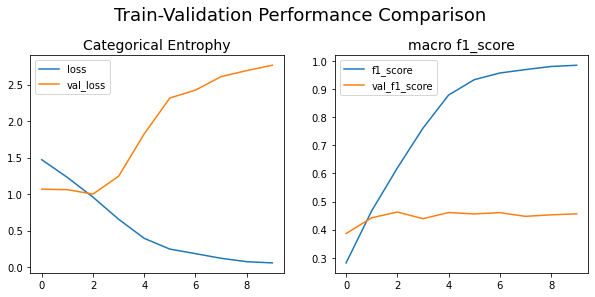

In [ ]:
plot_validation_performance(history5)

              precision    recall  f1-score   support

           0       0.50      0.51      0.50       138
           1       0.78      0.80      0.79      1055
           2       0.29      0.33      0.31       120
           3       0.29      0.21      0.24       181

    accuracy                           0.67      1494
   macro avg       0.47      0.46      0.46      1494
weighted avg       0.66      0.67      0.66      1494



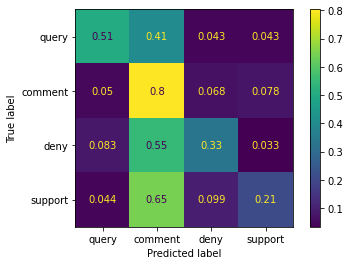

In [ ]:
name = 'models/BERT_base_2Input_trainable_03'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_03")
BERT_base_train_drop03.load_weights(checkpoint_filepath)
performance_class(BERT_base_train_drop03,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

* I try 0.1,0.3, 0.5, 0.7 dropout. The Best performance is 0.5 dropout rate with 0.47 macro f1.

## Regularization

In [ ]:
## Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder,' (tfhub_handle_encoder)')
print('Preprocessing model auto-selected:', tfhub_handle_preprocess,' (tfhub_handle_preprocess)')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3  (tfhub_handle_encoder)
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3  (tfhub_handle_preprocess)


In [110]:
def build_classifier_model_reg(dropout = 0.1,dense = 512,trainable = True,reg_lambda = 0):
  preprocessor = bert_preprocess_model(['Source', 'Reply'])
  text_preprocessed = preprocessor.output
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=trainable, name='BERT_encoder')
  outputs = encoder(text_preprocessed)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense2')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(4,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='softmax', name='classifier')(net)
  return tf.keras.Model(preprocessor.input, net)

## lambda 0.005

In [ ]:
BERT_base_reg_005 = build_classifier_model_reg(reg_lambda = 0.005)

In [ ]:
batch_size = 8
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_reg_005.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history6 = BERT_base_reg_005.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_reg_005')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
417/417 [==============================] - 273s 603ms/step - loss: 4.5621 - f1_score: 0.2714 - val_loss: 4.5235 - val_f1_score: 0.2401
Epoch 2/10
417/417 [==============================] - 251s 602ms/step - loss: 4.1764 - f1_score: 0.4931 - val_loss: 4.1187 - val_f1_score: 0.4495
Epoch 3/10
417/417 [==============================] - 251s 603ms/step - loss: 3.7535 - f1_score: 0.6052 - val_loss: 4.1360 - val_f1_score: 0.3738
Epoch 4/10
417/417 [==============================] - 252s 604ms/step - loss: 3.2846 - f1_score: 0.7462 - val_loss: 3.7488 - val_f1_score: 0.4524
Epoch 5/10
417/417 [==============================] - 252s 604ms/step - loss: 2.7910 - f1_score: 0.8608 - val_loss: 4.0706 - val_f1_score: 0.4354
Epoch 6/10
417/417 [==============================] - 252s 604ms/step - loss: 2.2305 - f1_score: 0.9197 - val_loss: 3.6904 - val_f1_score: 0.4504
Epoch 7/10
417/417 [=====================

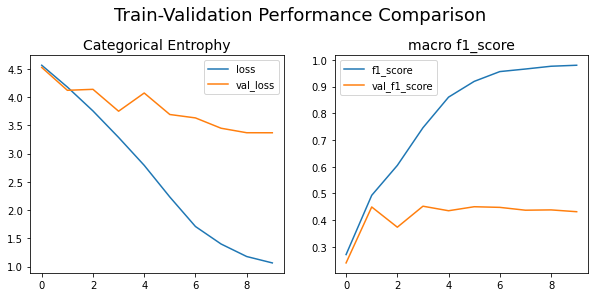

In [ ]:
plot_validation_performance(history6)

              precision    recall  f1-score   support

           0       0.42      0.60      0.49       138
           1       0.78      0.78      0.78      1055
           2       0.33      0.21      0.26       120
           3       0.29      0.27      0.28       181

    accuracy                           0.66      1494
   macro avg       0.46      0.46      0.45      1494
weighted avg       0.65      0.66      0.65      1494



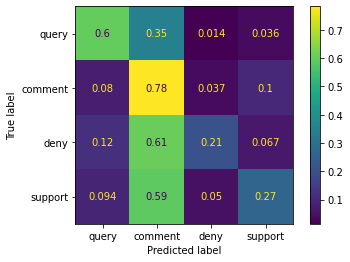

In [ ]:
name = 'models/BERT_base_2Input_reg_005'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_base_reg_005.load_weights(checkpoint_filepath)
performance_class(BERT_base_reg_005,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

## lambda 0.01

In [ ]:
BERT_base_reg_01 = build_classifier_model_reg(reg_lambda = 0.01)

In [ ]:
batch_size = 8
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_reg_01.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history6 = BERT_base_reg_01.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_reg_01')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
417/417 [==============================] - 263s 605ms/step - loss: 7.4889 - f1_score: 0.3615 - val_loss: 7.2444 - val_f1_score: 0.3147
Epoch 2/10
417/417 [==============================] - 252s 603ms/step - loss: 6.5725 - f1_score: 0.4904 - val_loss: 6.0936 - val_f1_score: 0.4148
Epoch 3/10
417/417 [==============================] - 252s 603ms/step - loss: 5.6284 - f1_score: 0.6369 - val_loss: 5.8096 - val_f1_score: 0.4270
Epoch 4/10
417/417 [==============================] - 251s 603ms/step - loss: 4.5688 - f1_score: 0.7852 - val_loss: 4.9670 - val_f1_score: 0.4322
Epoch 5/10
417/417 [==============================] - 251s 602ms/step - loss: 3.3827 - f1_score: 0.8998 - val_loss: 4.2633 - val_f1_score: 0.4350
Epoch 6/10
417/417 [==============================] - 251s 603ms/step - loss: 2.3182 - f1_score: 0.9400 - val_loss: 3.5695 - val_f1_score: 0.4401
Epoch 7/10
417/417 [=====================

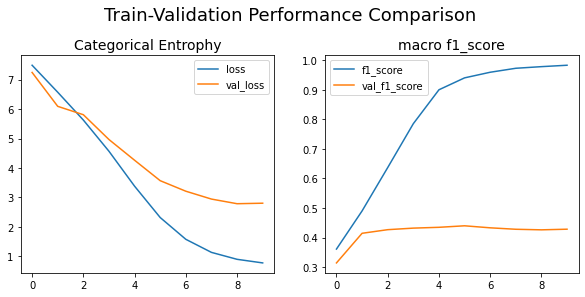

In [ ]:
plot_validation_performance(history6)

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       138
           1       0.77      0.85      0.81      1055
           2       0.35      0.22      0.27       120
           3       0.29      0.17      0.22       181

    accuracy                           0.68      1494
   macro avg       0.47      0.43      0.44      1494
weighted avg       0.65      0.68      0.66      1494



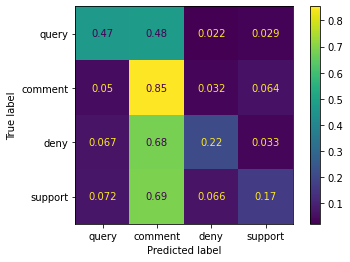

In [ ]:
name = 'models/BERT_base_2Input_reg_01'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_06")
BERT_base_reg_01.load_weights(checkpoint_filepath)
performance_class(BERT_base_reg_01,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

## lambda 0.05

In [ ]:
BERT_base_reg_05 = build_classifier_model_reg(reg_lambda = 0.05)

In [ ]:
batch_size = 8
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_reg_05.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history7 = BERT_base_reg_05.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_reg_05')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
417/417 [==============================] - 272s 604ms/step - loss: 31.3620 - f1_score: 0.3469 - val_loss: 28.9759 - val_f1_score: 0.2734
Epoch 2/15
417/417 [==============================] - 251s 601ms/step - loss: 24.5394 - f1_score: 0.4453 - val_loss: 20.4381 - val_f1_score: 0.3881
Epoch 3/15
417/417 [==============================] - 251s 601ms/step - loss: 16.9334 - f1_score: 0.5705 - val_loss: 13.9982 - val_f1_score: 0.4437
Epoch 4/15
417/417 [==============================] - 251s 601ms/step - loss: 10.9496 - f1_score: 0.6973 - val_loss: 9.1010 - val_f1_score: 0.4431
Epoch 5/15
417/417 [==============================] - 251s 601ms/step - loss: 6.5466 - f1_score: 0.8165 - val_loss: 5.7981 - val_f1_score: 0.4404
Epoch 6/15
417/417 [==============================] - 251s 602ms/step - loss: 2.9745 - f1_score: 0.8925 - val_loss: 3.0358 - val_f1_score: 0.4524
Epoch 7/15
417/417 [==============

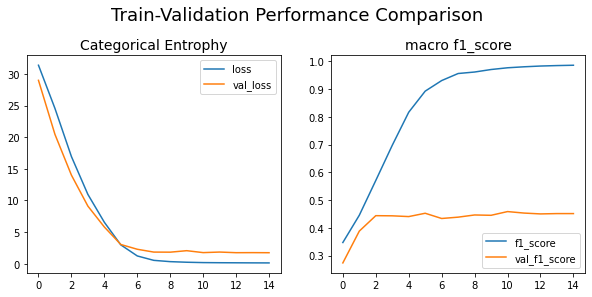

In [ ]:
plot_validation_performance(history7)

## lambda 0.03

In [ ]:
BERT_base_reg_03 = build_classifier_model_reg(reg_lambda = 0.03)

In [ ]:
batch_size = 8
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_reg_03.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history8 = BERT_base_reg_03.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_reg_03')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
417/417 [==============================] - 276s 607ms/step - loss: 19.4660 - f1_score: 0.3415 - val_loss: 17.9161 - val_f1_score: 0.3953
Epoch 2/15
417/417 [==============================] - 257s 617ms/step - loss: 16.2044 - f1_score: 0.4604 - val_loss: 14.1312 - val_f1_score: 0.3911
Epoch 3/15
417/417 [==============================] - 258s 618ms/step - loss: 12.0461 - f1_score: 0.5990 - val_loss: 10.4995 - val_f1_score: 0.4679
Epoch 4/15
417/417 [==============================] - 259s 620ms/step - loss: 8.5256 - f1_score: 0.7524 - val_loss: 7.7006 - val_f1_score: 0.4626
Epoch 5/15
417/417 [==============================] - 258s 619ms/step - loss: 5.2679 - f1_score: 0.8576 - val_loss: 4.8685 - val_f1_score: 0.4467
Epoch 6/15
417/417 [==============================] - 257s 617ms/step - loss: 2.6600 - f1_score: 0.9127 - val_loss: 3.3614 - val_f1_score: 0.4503
Epoch 7/15
417/417 [===============

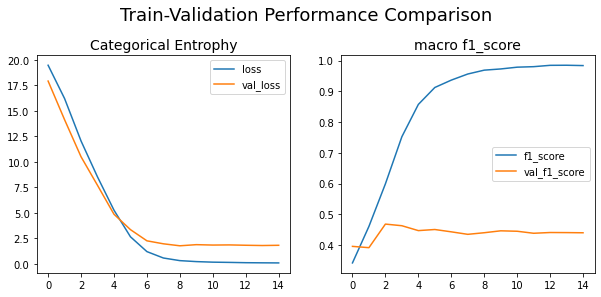

In [ ]:
plot_validation_performance(history8)

              precision    recall  f1-score   support

           0       0.44      0.59      0.50       138
           1       0.79      0.74      0.76      1055
           2       0.37      0.27      0.31       120
           3       0.26      0.34      0.30       181

    accuracy                           0.64      1494
   macro avg       0.47      0.48      0.47      1494
weighted avg       0.66      0.64      0.65      1494



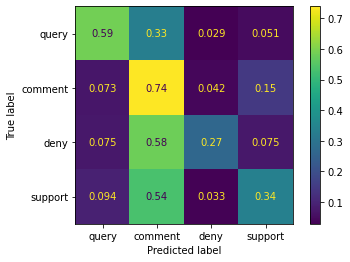

In [ ]:
name = 'models/BERT_base_2Input_reg_03'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_03")
BERT_base_reg_03.load_weights(checkpoint_filepath)
performance_class(BERT_base_reg_03,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

## Dropout + L2 regularisation

#### 0.5 + 0.005

In [ ]:
BERT_base_drop_05_reg_005 = build_classifier_model_reg(dropout = 0.5,reg_lambda = 0.005)

In [ ]:
batch_size = 8
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_drop_05_reg_005.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history9 = BERT_base_drop_05_reg_005.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_drop_05_reg_005')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
417/417 [==============================] - 271s 595ms/step - loss: 4.6428 - f1_score: 0.3326 - val_loss: 4.0993 - val_f1_score: 0.3743
Epoch 2/15
417/417 [==============================] - 256s 614ms/step - loss: 4.2643 - f1_score: 0.4136 - val_loss: 4.2360 - val_f1_score: 0.4113
Epoch 3/15
417/417 [==============================] - 257s 616ms/step - loss: 3.8890 - f1_score: 0.5730 - val_loss: 3.7083 - val_f1_score: 0.4333
Epoch 4/15
417/417 [==============================] - 256s 615ms/step - loss: 3.4338 - f1_score: 0.7066 - val_loss: 3.7415 - val_f1_score: 0.4363
Epoch 5/15
417/417 [==============================] - 257s 617ms/step - loss: 2.8029 - f1_score: 0.8326 - val_loss: 3.7964 - val_f1_score: 0.4294
Epoch 6/15
417/417 [==============================] - 257s 617ms/step - loss: 2.2451 - f1_score: 0.9040 - val_loss: 3.7803 - val_f1_score: 0.4346
Epoch 7/15
417/417 [=====================

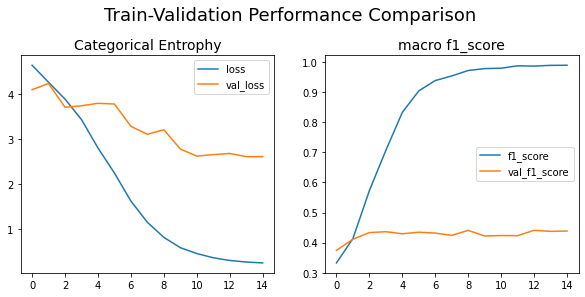

In [ ]:
plot_validation_performance(history9)

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       138
           1       0.77      0.82      0.80      1055
           2       0.28      0.23      0.25       120
           3       0.27      0.19      0.23       181

    accuracy                           0.67      1494
   macro avg       0.45      0.44      0.44      1494
weighted avg       0.64      0.67      0.65      1494



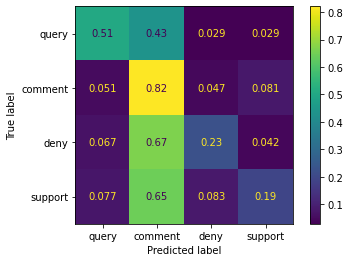

In [ ]:
name = 'models/BERT_base_2Input_drop_05_reg_005'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_13")
BERT_base_drop_05_reg_005.load_weights(checkpoint_filepath)
performance_class(BERT_base_drop_05_reg_005,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

### 0.5 + 0.001

In [ ]:
BERT_base_drop_05_reg_001 = build_classifier_model_reg(dropout = 0.5,reg_lambda = 0.001)

In [ ]:
batch_size = 8
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_drop_05_reg_001.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history10 = BERT_base_drop_05_reg_001.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_drop_05_reg_001')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
417/417 [==============================] - 278s 616ms/step - loss: 2.1440 - f1_score: 0.3235 - val_loss: 1.6763 - val_f1_score: 0.3790
Epoch 2/15
417/417 [==============================] - 255s 611ms/step - loss: 1.9133 - f1_score: 0.4302 - val_loss: 1.6112 - val_f1_score: 0.4097
Epoch 3/15
417/417 [==============================] - 256s 614ms/step - loss: 1.7671 - f1_score: 0.5338 - val_loss: 1.7093 - val_f1_score: 0.4408
Epoch 4/15
417/417 [==============================] - 256s 614ms/step - loss: 1.3928 - f1_score: 0.6842 - val_loss: 2.0411 - val_f1_score: 0.4376
Epoch 5/15
417/417 [==============================] - 256s 614ms/step - loss: 1.1076 - f1_score: 0.8215 - val_loss: 2.1323 - val_f1_score: 0.4477
Epoch 6/15
417/417 [==============================] - 252s 604ms/step - loss: 0.9503 - f1_score: 0.8954 - val_loss: 2.6644 - val_f1_score: 0.4238
Epoch 7/15
417/417 [=====================

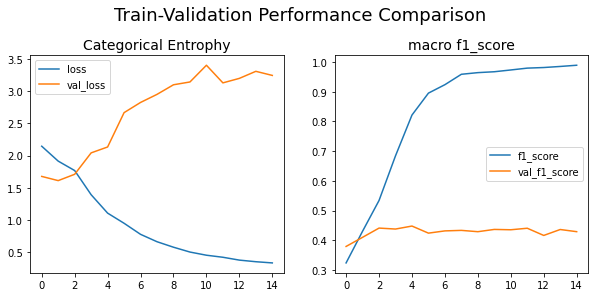

In [ ]:
plot_validation_performance(history10)

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       138
           1       0.78      0.77      0.77      1055
           2       0.25      0.26      0.25       120
           3       0.26      0.29      0.27       181

    accuracy                           0.64      1494
   macro avg       0.46      0.44      0.45      1494
weighted avg       0.65      0.64      0.65      1494



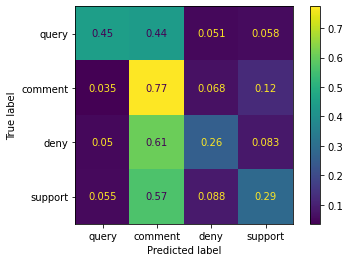

In [ ]:
name = 'models/BERT_base_2Input_drop_05_reg_001'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_05")
BERT_base_drop_05_reg_001.load_weights(checkpoint_filepath)
performance_class(BERT_base_drop_05_reg_001,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

### 0.5 + 0.03 (Best dropout + reg)

In [111]:
BERT_base_drop_05_reg_003 = build_classifier_model_reg(dropout = 0.5,reg_lambda = 0.03)

In [ ]:
batch_size = 8
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_base_drop_05_reg_003.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history11 = BERT_base_drop_05_reg_003.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=8,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_drop_05_reg_003')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
417/417 [==============================] - 276s 612ms/step - loss: 19.8830 - f1_score: 0.2938 - val_loss: 18.3665 - val_f1_score: 0.2707
Epoch 2/15
417/417 [==============================] - 256s 614ms/step - loss: 16.6357 - f1_score: 0.4164 - val_loss: 14.9139 - val_f1_score: 0.3396
Epoch 3/15
417/417 [==============================] - 256s 614ms/step - loss: 12.5018 - f1_score: 0.5515 - val_loss: 10.9390 - val_f1_score: 0.4390
Epoch 4/15
417/417 [==============================] - 256s 613ms/step - loss: 8.9561 - f1_score: 0.7113 - val_loss: 7.7766 - val_f1_score: 0.4597
Epoch 5/15
417/417 [==============================] - 256s 615ms/step - loss: 5.8395 - f1_score: 0.8094 - val_loss: 5.2655 - val_f1_score: 0.4377
Epoch 6/15
417/417 [==============================] - 257s 617ms/step - loss: 3.1925 - f1_score: 0.8942 - val_loss: 3.6268 - val_f1_score: 0.4256
Epoch 7/15
417/417 [===============

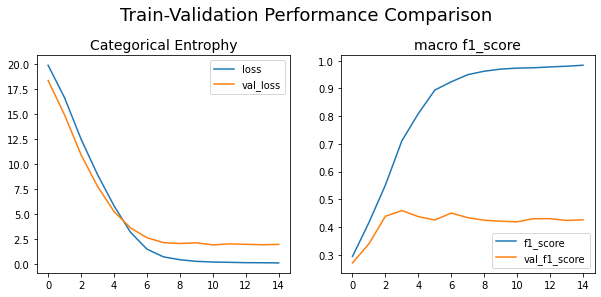

In [ ]:
plot_validation_performance(history11)

              precision    recall  f1-score   support

           0       0.48      0.58      0.53       138
           1       0.77      0.85      0.81      1055
           2       0.38      0.22      0.28       120
           3       0.34      0.17      0.23       181

    accuracy                           0.69      1494
   macro avg       0.49      0.46      0.46      1494
weighted avg       0.66      0.69      0.67      1494



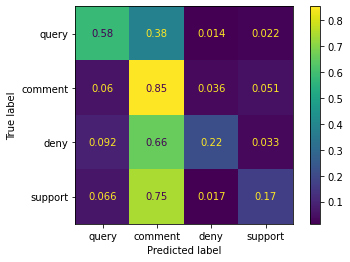

In [ ]:
name = 'models/BERT_base_2Input_drop_05_reg_003'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_base_drop_05_reg_003.load_weights(checkpoint_filepath)
performance_class(BERT_base_drop_05_reg_003,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       122
           1       0.78      0.90      0.83      1026
           2       0.47      0.14      0.21       133
           3       0.31      0.17      0.22       148

    accuracy                           0.73      1429
   macro avg       0.54      0.46      0.47      1429
weighted avg       0.69      0.73      0.69      1429



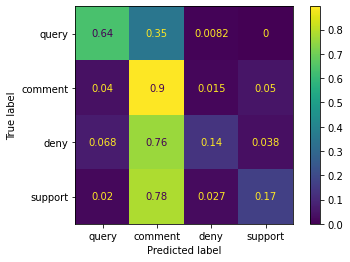

In [112]:
name = 'models/BERT_base_2Input_drop_05_reg_003'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_base_drop_05_reg_003.load_weights(checkpoint_filepath)
performance_class(BERT_base_drop_05_reg_003,[x_test_source_np,x_test_np],test_y_tweet, ["query","comment","deny","support"] )

# More dense layers

In [94]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder,' (tfhub_handle_encoder)')
print('Preprocessing model auto-selected:', tfhub_handle_preprocess,' (tfhub_handle_preprocess)')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3  (tfhub_handle_encoder)
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3  (tfhub_handle_preprocess)


In [ ]:
def build_classifier_model_reg_2layers(dropout = 0.1,dense = 512,trainable = True,reg_lambda = 0):
  preprocessor = bert_preprocess_model(['Source', 'Reply'])
  text_preprocessed = preprocessor.output
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=trainable, name='BERT_encoder')
  outputs = encoder(text_preprocessed)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense2')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(dense/2,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(4,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='softmax', name='classifier')(net)
  return tf.keras.Model(preprocessor.input, net)

In [ ]:
BERT_BASE_2layer = build_classifier_model_reg_2layers(dropout = 0.0,dense = 768)

In [ ]:
batch_size = 16
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_2layer.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history13 = BERT_BASE_2layer.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_2layer')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
209/209 [==============================] - 241s 1s/step - loss: 1.4136 - f1_score: 0.2749 - val_loss: 1.4070 - val_f1_score: 0.1850
Epoch 2/10
209/209 [==============================] - 220s 1s/step - loss: 1.1767 - f1_score: 0.4216 - val_loss: 1.2686 - val_f1_score: 0.4213
Epoch 3/10
209/209 [==============================] - 219s 1s/step - loss: 0.9549 - f1_score: 0.5664 - val_loss: 1.4908 - val_f1_score: 0.3499
Epoch 4/10
209/209 [==============================] - 220s 1s/step - loss: 0.6536 - f1_score: 0.6881 - val_loss: 1.1520 - val_f1_score: 0.4396
Epoch 5/10
209/209 [==============================] - 220s 1s/step - loss: 0.4251 - f1_score: 0.8051 - val_loss: 1.4082 - val_f1_score: 0.4506
Epoch 6/10
209/209 [==============================] - 219s 1s/step - loss: 0.2668 - f1_score: 0.8826 - val_loss: 1.7082 - val_f1_score: 0.4585
Epoch 7/10
209/209 [==============================] - 220s 

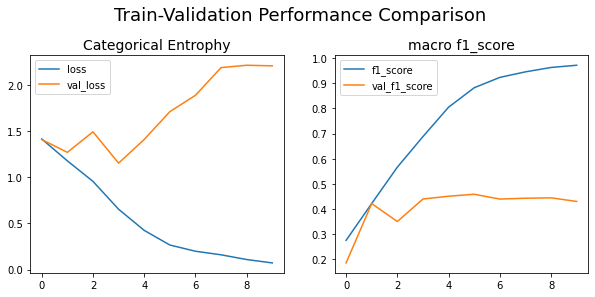

In [ ]:
plot_validation_performance(history13)

              precision    recall  f1-score   support

           0       0.59      0.45      0.51       138
           1       0.77      0.82      0.80      1055
           2       0.25      0.23      0.24       120
           3       0.31      0.26      0.28       181

    accuracy                           0.67      1494
   macro avg       0.48      0.44      0.46      1494
weighted avg       0.66      0.67      0.66      1494



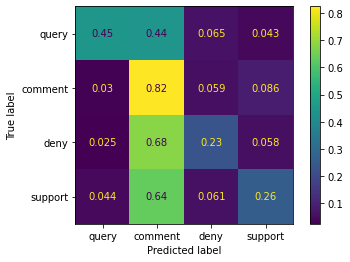

In [ ]:
name = 'models/BERT_base_2Input_2layer'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_06")
BERT_BASE_2layer.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_2layer,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

In [ ]:
BERT_BASE_2layer_05 = build_classifier_model_reg_2layers(dropout = 0.5,dense = 768)

In [ ]:
batch_size = 16
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_2layer_05.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history14 = BERT_BASE_2layer_05.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_2layer05')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
209/209 [==============================] - 241s 1s/step - loss: 1.6912 - f1_score: 0.2800 - val_loss: 1.1923 - val_f1_score: 0.2808
Epoch 2/10
209/209 [==============================] - 221s 1s/step - loss: 1.4620 - f1_score: 0.3014 - val_loss: 1.4291 - val_f1_score: 0.3899
Epoch 3/10
209/209 [==============================] - 221s 1s/step - loss: 1.2257 - f1_score: 0.4293 - val_loss: 1.0737 - val_f1_score: 0.4595
Epoch 4/10
209/209 [==============================] - 221s 1s/step - loss: 0.9090 - f1_score: 0.5750 - val_loss: 1.3098 - val_f1_score: 0.4384
Epoch 5/10
209/209 [==============================] - 222s 1s/step - loss: 0.6273 - f1_score: 0.7080 - val_loss: 1.3628 - val_f1_score: 0.4565
Epoch 6/10
209/209 [==============================] - 222s 1s/step - loss: 0.3882 - f1_score: 0.8197 - val_loss: 1.4528 - val_f1_score: 0.4589
Epoch 7/10
209/209 [==============================] - 221s 

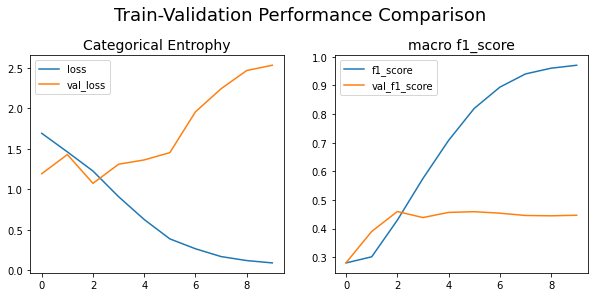

In [ ]:
plot_validation_performance(history14)

              precision    recall  f1-score   support

           0       0.47      0.64      0.54       138
           1       0.80      0.69      0.74      1055
           2       0.19      0.45      0.27       120
           3       0.39      0.23      0.29       181

    accuracy                           0.61      1494
   macro avg       0.46      0.50      0.46      1494
weighted avg       0.67      0.61      0.63      1494



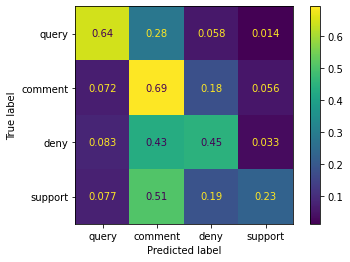

In [ ]:
name = 'models/BERT_base_2Input_2layer05'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_03")
BERT_BASE_2layer_05.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_2layer_05,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

In [ ]:
BERT_BASE_2layer_07 = build_classifier_model_reg_2layers(dropout = 0.7,dense = 768)

In [ ]:
batch_size = 16
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_2layer_07.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history15 = BERT_BASE_2layer_07.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_2layer07')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
209/209 [==============================] - 242s 1s/step - loss: 1.9741 - f1_score: 0.2821 - val_loss: 1.2803 - val_f1_score: 0.2111
Epoch 2/10
209/209 [==============================] - 221s 1s/step - loss: 1.6397 - f1_score: 0.2384 - val_loss: 1.3129 - val_f1_score: 0.3573
Epoch 3/10
209/209 [==============================] - 222s 1s/step - loss: 1.4077 - f1_score: 0.3382 - val_loss: 1.1220 - val_f1_score: 0.3882
Epoch 4/10
209/209 [==============================] - 221s 1s/step - loss: 1.2858 - f1_score: 0.3761 - val_loss: 0.9701 - val_f1_score: 0.3872
Epoch 5/10
209/209 [==============================] - 222s 1s/step - loss: 1.0353 - f1_score: 0.4993 - val_loss: 1.2739 - val_f1_score: 0.4323
Epoch 6/10
209/209 [==============================] - 221s 1s/step - loss: 0.8388 - f1_score: 0.6178 - val_loss: 1.2858 - val_f1_score: 0.4576
Epoch 7/10
209/209 [==============================] - 221s 

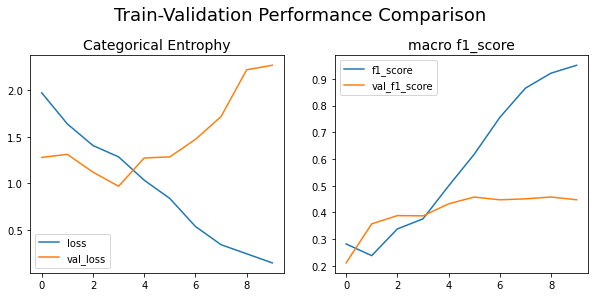

In [ ]:
plot_validation_performance(history15)

              precision    recall  f1-score   support

           0       0.51      0.56      0.53       138
           1       0.77      0.80      0.79      1055
           2       0.28      0.28      0.28       120
           3       0.27      0.20      0.23       181

    accuracy                           0.66      1494
   macro avg       0.46      0.46      0.46      1494
weighted avg       0.65      0.66      0.65      1494



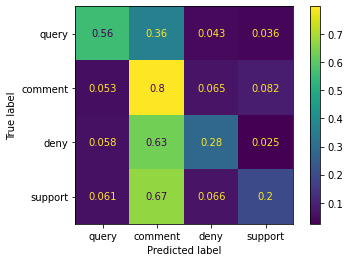

In [ ]:
name = 'models/BERT_base_2Input_2layer07'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_09")
BERT_BASE_2layer_07.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_2layer_07,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

# 4 dense layers

In [114]:
def build_classifier_model_reg_4layers(dropout = 0,dense = 512,trainable = True,reg_lambda = 0):
  preprocessor = bert_preprocess_model(['Source', 'Reply'])
  text_preprocessed = preprocessor.output
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=trainable, name='BERT_encoder')
  outputs = encoder(text_preprocessed)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense4')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense3')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense2')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(dense/2,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(4,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='softmax', name='classifier')(net)
  return tf.keras.Model(preprocessor.input, net)

In [115]:
BERT_BASE_4layer= build_classifier_model_reg_4layers(dense = 768)

In [ ]:
batch_size = 16
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_4layer.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history16 = BERT_BASE_4layer.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_4layer')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
209/209 [==============================] - 241s 1s/step - loss: 1.3827 - f1_score: 0.3304 - val_loss: 1.2060 - val_f1_score: 0.3358
Epoch 2/10
209/209 [==============================] - 222s 1s/step - loss: 1.2072 - f1_score: 0.4297 - val_loss: 1.1381 - val_f1_score: 0.4369
Epoch 3/10
209/209 [==============================] - 222s 1s/step - loss: 0.9909 - f1_score: 0.5483 - val_loss: 1.1400 - val_f1_score: 0.4390
Epoch 4/10
209/209 [==============================] - 222s 1s/step - loss: 0.7125 - f1_score: 0.6808 - val_loss: 1.1459 - val_f1_score: 0.4450
Epoch 5/10
209/209 [==============================] - 221s 1s/step - loss: 0.4621 - f1_score: 0.7990 - val_loss: 1.3315 - val_f1_score: 0.4591
Epoch 6/10
209/209 [==============================] - 221s 1s/step - loss: 0.3014 - f1_score: 0.8827 - val_loss: 1.5267 - val_f1_score: 0.4714
Epoch 7/10
209/209 [==============================] - 222s 

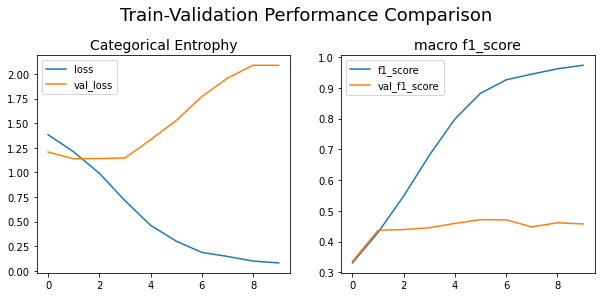

In [ ]:
plot_validation_performance(history16)

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       138
           1       0.78      0.80      0.79      1055
           2       0.31      0.31      0.31       120
           3       0.29      0.25      0.27       181

    accuracy                           0.67      1494
   macro avg       0.48      0.46      0.47      1494
weighted avg       0.66      0.67      0.66      1494



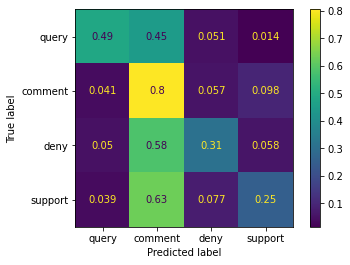

In [ ]:
name = 'models/BERT_base_2Input_4layer'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_06")
BERT_BASE_4layer.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

              precision    recall  f1-score   support

           0       0.66      0.56      0.60       122
           1       0.78      0.84      0.81      1026
           2       0.30      0.14      0.19       133
           3       0.29      0.31      0.30       148

    accuracy                           0.70      1429
   macro avg       0.51      0.46      0.48      1429
weighted avg       0.68      0.70      0.68      1429



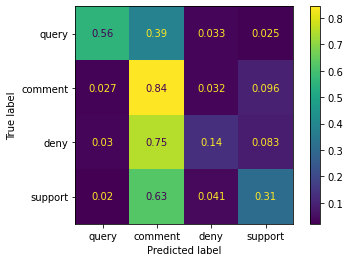

In [116]:
name = 'models/BERT_base_2Input_4layer'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_06")
BERT_BASE_4layer.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer,[x_test_source_np,x_test_np],test_y_tweet, ["query","comment","deny","support"] )

## 4 dense + 0.3 dropout

In [ ]:
BERT_BASE_4layer_03= build_classifier_model_reg_4layers(dense = 768,dropout = 0.3)

In [ ]:
batch_size = 16
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_4layer_03.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history17 = BERT_BASE_4layer_03.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_4layer03')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
209/209 [==============================] - 243s 1s/step - loss: 1.5693 - f1_score: 0.2155 - val_loss: 1.3674 - val_f1_score: 0.0684
Epoch 2/15
209/209 [==============================] - 223s 1s/step - loss: 1.3499 - f1_score: 0.3335 - val_loss: 1.2958 - val_f1_score: 0.3993
Epoch 3/15
209/209 [==============================] - 223s 1s/step - loss: 1.2041 - f1_score: 0.4284 - val_loss: 1.5903 - val_f1_score: 0.3026
Epoch 4/15
209/209 [==============================] - 223s 1s/step - loss: 0.9761 - f1_score: 0.5456 - val_loss: 1.1833 - val_f1_score: 0.4379
Epoch 5/15
209/209 [==============================] - 224s 1s/step - loss: 0.7217 - f1_score: 0.6795 - val_loss: 1.9040 - val_f1_score: 0.4210
Epoch 6/15
209/209 [==============================] - 224s 1s/step - loss: 0.4724 - f1_score: 0.7953 - val_loss: 1.6768 - val_f1_score: 0.4417
Epoch 7/15
209/209 [==============================] - 223s 

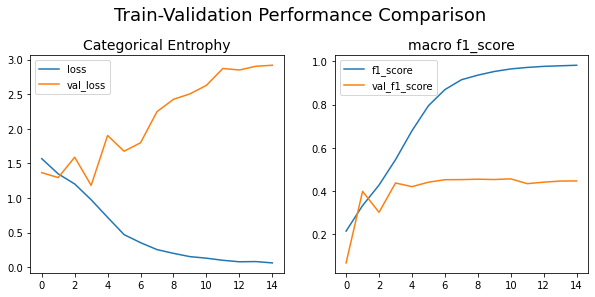

In [ ]:
plot_validation_performance(history17)

              precision    recall  f1-score   support

           0       0.48      0.56      0.52       138
           1       0.78      0.86      0.81      1055
           2       0.33      0.29      0.31       120
           3       0.35      0.13      0.19       181

    accuracy                           0.69      1494
   macro avg       0.49      0.46      0.46      1494
weighted avg       0.66      0.69      0.67      1494



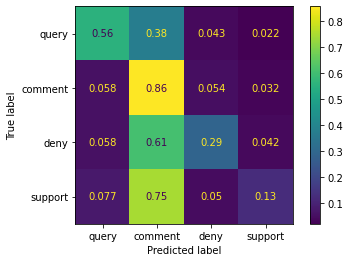

In [ ]:
name = 'models/BERT_base_2Input_4layer03'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_11")
BERT_BASE_4layer_03.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer_03,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

## 4 denses + 0.1

In [53]:
BERT_BASE_4layer_01= build_classifier_model_reg_4layers(dense = 768,dropout = 0.1)

In [ ]:
batch_size = 16
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_4layer_01.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history19 = BERT_BASE_4layer_01.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_4layer01')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
209/209 [==============================] - 236s 1s/step - loss: 1.4133 - f1_score: 0.2599 - val_loss: 1.5971 - val_f1_score: 0.2751
Epoch 2/15
209/209 [==============================] - 215s 1s/step - loss: 1.2640 - f1_score: 0.3729 - val_loss: 1.3310 - val_f1_score: 0.3212
Epoch 3/15
209/209 [==============================] - 215s 1s/step - loss: 1.1456 - f1_score: 0.4507 - val_loss: 1.0250 - val_f1_score: 0.4424
Epoch 4/15
209/209 [==============================] - 217s 1s/step - loss: 0.8836 - f1_score: 0.5903 - val_loss: 1.0650 - val_f1_score: 0.4768
Epoch 5/15
209/209 [==============================] - 219s 1s/step - loss: 0.6475 - f1_score: 0.7071 - val_loss: 1.3109 - val_f1_score: 0.4516
Epoch 6/15
209/209 [==============================] - 218s 1s/step - loss: 0.5010 - f1_score: 0.8207 - val_loss: 1.2451 - val_f1_score: 0.4593
Epoch 7/15
209/209 [==============================] - 218s 

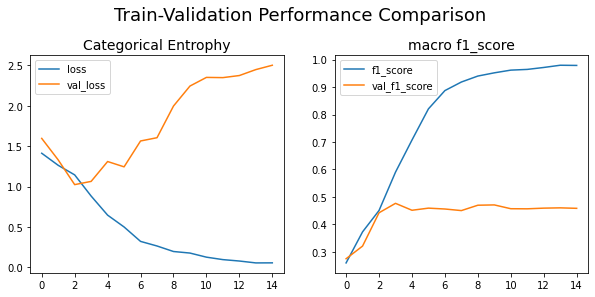

In [ ]:
plot_validation_performance(history19)

              precision    recall  f1-score   support

           0       0.49      0.61      0.54       138
           1       0.79      0.76      0.78      1055
           2       0.26      0.42      0.32       120
           3       0.34      0.22      0.27       181

    accuracy                           0.65      1494
   macro avg       0.47      0.50      0.48      1494
weighted avg       0.67      0.65      0.66      1494



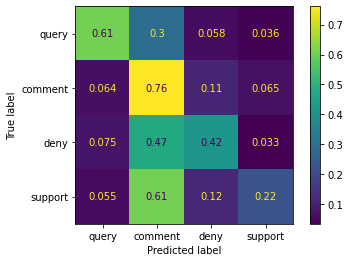

In [54]:
name = 'models/BERT_base_2Input_4layer01'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_04")
BERT_BASE_4layer_01.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer_01,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

## 4 desne 0.2 (Best model)

In [ ]:
BERT_BASE_4layer_02= build_classifier_model_reg_4layers(dense = 768,dropout = 0.2)

In [ ]:
batch_size = 16
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_4layer_02.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history20 = BERT_BASE_4layer_02.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_4layer02')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
209/209 [==============================] - 241s 1s/step - loss: 1.4975 - f1_score: 0.2951 - val_loss: 1.9406 - val_f1_score: 0.1601
Epoch 2/15
209/209 [==============================] - 220s 1s/step - loss: 1.3633 - f1_score: 0.3190 - val_loss: 1.1997 - val_f1_score: 0.4009
Epoch 3/15
209/209 [==============================] - 221s 1s/step - loss: 1.2185 - f1_score: 0.4233 - val_loss: 1.0903 - val_f1_score: 0.4439
Epoch 4/15
209/209 [==============================] - 222s 1s/step - loss: 0.9353 - f1_score: 0.5763 - val_loss: 1.1517 - val_f1_score: 0.4122
Epoch 5/15
209/209 [==============================] - 219s 1s/step - loss: 0.6652 - f1_score: 0.7058 - val_loss: 1.5024 - val_f1_score: 0.4385
Epoch 6/15
209/209 [==============================] - 218s 1s/step - loss: 0.4341 - f1_score: 0.8144 - val_loss: 1.4632 - val_f1_score: 0.4525
Epoch 7/15
209/209 [==============================] - 218s 

              precision    recall  f1-score   support

           0       0.54      0.55      0.54       138
           1       0.79      0.79      0.79      1055
           2       0.29      0.33      0.31       120
           3       0.30      0.24      0.27       181

    accuracy                           0.67      1494
   macro avg       0.48      0.48      0.48      1494
weighted avg       0.66      0.67      0.67      1494



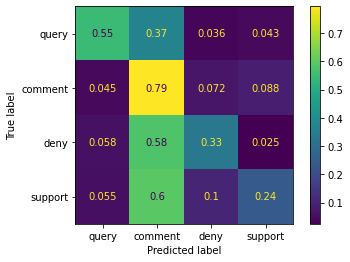

In [ ]:
name = 'models/BERT_base_2Input_4layer02'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_08")
BERT_BASE_4layer_02.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer_02,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       122
           1       0.79      0.82      0.81      1026
           2       0.32      0.24      0.27       133
           3       0.29      0.27      0.28       148

    accuracy                           0.69      1429
   macro avg       0.50      0.49      0.49      1429
weighted avg       0.68      0.69      0.69      1429



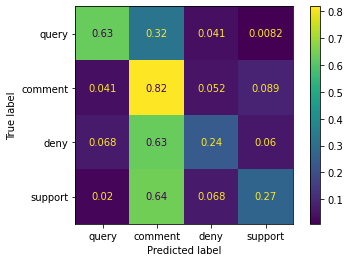

In [ ]:
name = 'models/BERT_base_2Input_4layer02'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_08")
BERT_BASE_4layer_02.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer_02,[x_test_source_np,x_test_np],test_y_tweet, ["query","comment","deny","support"] )

## 4 dense + 0.15

In [49]:
BERT_BASE_4layer_015= build_classifier_model_reg_4layers(dense = 768,dropout = 0.15)

In [53]:
batch_size = 16
epochs = 15
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [54]:
BERT_BASE_4layer_015.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [55]:
print(f'Training model with {tfhub_handle_encoder}')
history22 = BERT_BASE_4layer_015.fit(x=[x_source_np,x_train_np],y=train_y_tweet,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight,
                               callbacks=[get_callbacks('models/BERT_base_2Input_4layer015')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/15
209/209 [==============================] - 238s 1s/step - loss: 1.2234 - f1_score: 0.3625 - val_loss: 1.2014 - val_f1_score: 0.3674
Epoch 2/15
209/209 [==============================] - 224s 1s/step - loss: 1.1675 - f1_score: 0.4212 - val_loss: 1.3517 - val_f1_score: 0.3053
Epoch 3/15
209/209 [==============================] - 224s 1s/step - loss: 1.0273 - f1_score: 0.4964 - val_loss: 1.1686 - val_f1_score: 0.4143
Epoch 4/15
209/209 [==============================] - 224s 1s/step - loss: 0.8461 - f1_score: 0.5896 - val_loss: 1.0748 - val_f1_score: 0.4538
Epoch 5/15
209/209 [==============================] - 224s 1s/step - loss: 0.6751 - f1_score: 0.6652 - val_loss: 1.3275 - val_f1_score: 0.4286
Epoch 6/15
209/209 [==============================] - 224s 1s/step - loss: 0.5119 - f1_score: 0.7425 - val_loss: 1.2897 - val_f1_score: 0.4349
Epoch 7/15
209/209 [==============================] - 224s 

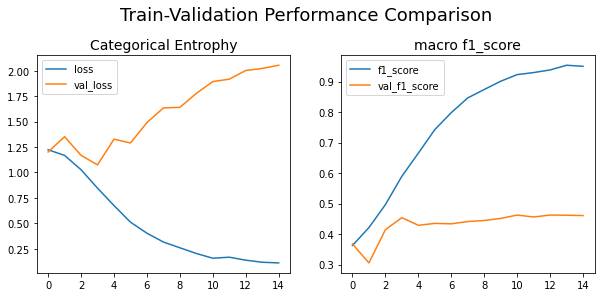

In [56]:
plot_validation_performance(history22)

# Plus Reddit

In [ ]:
reddit_tweet_train['Class'].value_counts()

comment    4501
support     486
deny        332
query       323
Name: Class, dtype: int64

In [63]:
class_weight_extra = { 0: 4.36687306501548,
                      1: 0.313374805598756,
                      2: 4.248493975903616,
                      3: 2.9022633744856
}

In [117]:
BERT_BASE_4layer_extra = build_classifier_model_reg_4layers(dense = 768)

In [ ]:
batch_size = 16
epochs = 10
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_BASE_4layer_extra.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history16 = BERT_BASE_4layer_extra.fit(x=[x_reddit_source_np,x_reddit_np],y=y_reddit,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight_extra,
                               callbacks=[get_callbacks('models/BERT_base_2Input_4layer_extra')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
353/353 [==============================] - 373s 989ms/step - loss: 1.3358 - f1_score: 0.3062 - val_loss: 1.2163 - val_f1_score: 0.3441
Epoch 2/10
353/353 [==============================] - 350s 990ms/step - loss: 1.0999 - f1_score: 0.4498 - val_loss: 1.3403 - val_f1_score: 0.4043
Epoch 3/10
353/353 [==============================] - 349s 989ms/step - loss: 0.8324 - f1_score: 0.5723 - val_loss: 1.0388 - val_f1_score: 0.4638
Epoch 4/10
353/353 [==============================] - 349s 990ms/step - loss: 0.5821 - f1_score: 0.6943 - val_loss: 1.1728 - val_f1_score: 0.4455
Epoch 5/10
353/353 [==============================] - 350s 990ms/step - loss: 0.3903 - f1_score: 0.7992 - val_loss: 1.4050 - val_f1_score: 0.4527
Epoch 6/10
353/353 [==============================] - 349s 988ms/step - loss: 0.2729 - f1_score: 0.8653 - val_loss: 1.5521 - val_f1_score: 0.4462
Epoch 7/10
353/353 [=====================

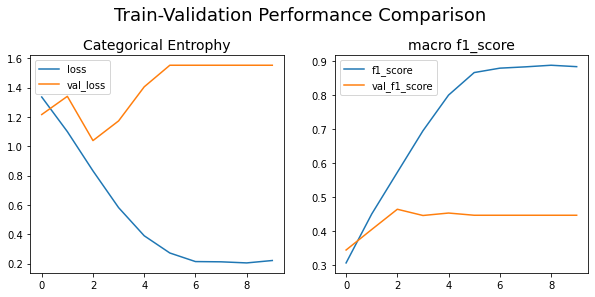

In [ ]:
plot_validation_performance(history16)

              precision    recall  f1-score   support

           0       0.39      0.72      0.51       138
           1       0.80      0.77      0.78      1055
           2       0.40      0.20      0.27       120
           3       0.31      0.29      0.30       181

    accuracy                           0.66      1494
   macro avg       0.48      0.49      0.46      1494
weighted avg       0.67      0.66      0.66      1494



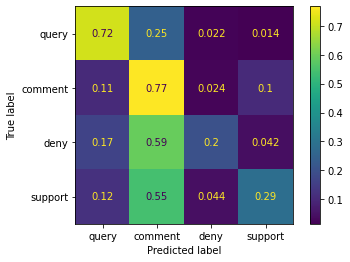

In [ ]:
name = 'models/BERT_base_2Input_4layer_extra'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_03")
BERT_BASE_4layer_extra.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer_extra,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

              precision    recall  f1-score   support

           0       0.47      0.78      0.59       122
           1       0.80      0.77      0.78      1026
           2       0.44      0.12      0.19       133
           3       0.25      0.36      0.30       148

    accuracy                           0.66      1429
   macro avg       0.49      0.51      0.46      1429
weighted avg       0.68      0.66      0.66      1429



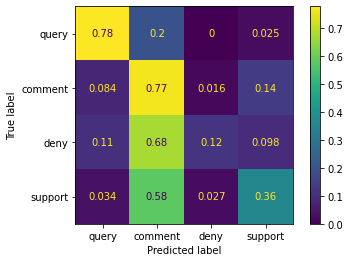

In [118]:
name = 'models/BERT_base_2Input_4layer_extra'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_03")
BERT_BASE_4layer_extra.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer_extra,[x_test_source_np,x_test_np],test_y_tweet, ["query","comment","deny","support"] )

In [59]:
BERT_BASE_4layer_extra02 = build_classifier_model_reg_4layers(dense = 768,dropout = 0.2)

In [60]:
batch_size = 16
epochs = 20
steps_per_epoch = len(train_x_text_tweet)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [61]:
BERT_BASE_4layer_extra02.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [64]:
print(f'Training model with {tfhub_handle_encoder}')
history20 = BERT_BASE_4layer_extra02.fit(x=[x_reddit_source_np,x_reddit_np],y=y_reddit,
                               validation_data=([x_val_source_np,x_val_np],val_y_tweet),
                               epochs=epochs,batch_size=16,verbose=1, class_weight=class_weight_extra,
                               callbacks=[get_callbacks('models/BERT_base_2Input_4layer_extra02')])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/20
353/353 [==============================] - 378s 1s/step - loss: 1.4900 - f1_score: 0.2439 - val_loss: 1.7611 - val_f1_score: 0.0858
Epoch 2/20
353/353 [==============================] - 360s 1s/step - loss: 1.3559 - f1_score: 0.3457 - val_loss: 1.5264 - val_f1_score: 0.2511
Epoch 3/20
353/353 [==============================] - 362s 1s/step - loss: 1.3569 - f1_score: 0.3317 - val_loss: 1.4477 - val_f1_score: 0.2952
Epoch 4/20
353/353 [==============================] - 363s 1s/step - loss: 1.2158 - f1_score: 0.4070 - val_loss: 1.7122 - val_f1_score: 0.2786
Epoch 5/20
353/353 [==============================] - 363s 1s/step - loss: 1.0240 - f1_score: 0.4760 - val_loss: 1.6692 - val_f1_score: 0.3166
Epoch 6/20
353/353 [==============================] - 362s 1s/step - loss: 0.8817 - f1_score: 0.5611 - val_loss: 1.3477 - val_f1_score: 0.4259
Epoch 7/20
353/353 [==============================] - 363s 

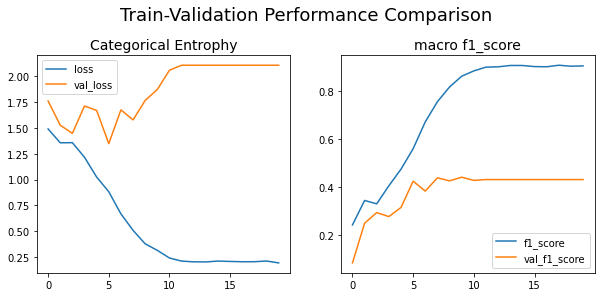

In [65]:
plot_validation_performance(history20)

              precision    recall  f1-score   support

           0       0.47      0.62      0.53       138
           1       0.78      0.73      0.75      1055
           2       0.23      0.27      0.25       120
           3       0.25      0.25      0.25       181

    accuracy                           0.62      1494
   macro avg       0.43      0.46      0.44      1494
weighted avg       0.64      0.62      0.63      1494



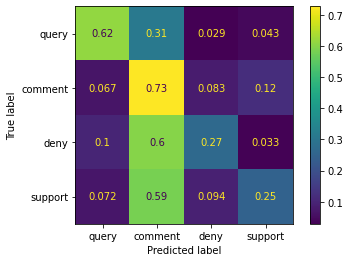

In [ ]:
performance_class(BERT_BASE_4layer_extra02,[x_val_source_np,x_val_np],val_y_tweet, ["query","comment","deny","support"] )

# Test on real word data

In [78]:
real_twitter_raw = pd.read_csv("drive/My Drive/Rumour_data/realword_tweet.csv")

In [79]:
real_twitter_raw2 = preprocess(real_twitter_raw)

In [80]:
real_twitter_raw2.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,Text_tokenize
0,Source,0,-1,Let's say it loud and clear: #ImmigrantsAreEss...,ImmigrantsAreEssential,-1,Let's say it loud and clear: #ImmigrantsAreEss...
1,Reply,1,0,Please include Mixed Status Families in Immigr...,ImmigrantsAreEssential,comment,Please include Mixed Status Families in Immigr...
2,Reply,2,0,Yeah will then why it take me 3 years to get m...,ImmigrantsAreEssential,deny,Yeah will then why it take me 3 years to get m...
3,Reply,3,0,"I'm a Registered Nurse, we are short staffed a...",ImmigrantsAreEssential,comment,"I'm a Registered Nurse, we are short staffed a..."
4,Reply,4,0,Please include the spouses and children of U.S...,ImmigrantsAreEssential,comment,Please include the spouses and children of U.S...


In [81]:
realtwitter_final = concat_source_to_reply(real_twitter_raw2)

In [82]:
realtwitter_final.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class,Text_tokenize,source_text
0,Reply,1,0,Please include Mixed Status Families in Immigr...,ImmigrantsAreEssential,comment,please include mixed status families in immigr...,let's say it loud and clear: #immigrantsareess...
1,Reply,2,0,Yeah will then why it take me 3 years to get m...,ImmigrantsAreEssential,deny,yeah will then why it take me 3 years to get m...,let's say it loud and clear: #immigrantsareess...
2,Reply,3,0,"I'm a Registered Nurse, we are short staffed a...",ImmigrantsAreEssential,comment,"i'm a registered nurse, we are short staffed a...",let's say it loud and clear: #immigrantsareess...
3,Reply,4,0,Please include the spouses and children of U.S...,ImmigrantsAreEssential,comment,please include the spouses and children of u.s...,let's say it loud and clear: #immigrantsareess...
4,Reply,5,0,"All immigrants are essential. Also, legal immi...",ImmigrantsAreEssential,support,"all immigrants are essential. also, legal immi...",let's say it loud and clear: #immigrantsareess...


In [83]:
#Encode 
encode = {
    "query" : 0,
    "comment"  : 1,       
    "deny" : 2,    
    "support" : 3
}

realtwitter_final["predicted_Class"] = realtwitter_final["Class"].apply(lambda x: encode[x])

In [84]:
test_x_text_realtweet = realtwitter_final['Text_tokenize'].values.tolist()
test_source_realtweet = realtwitter_final['source_text'].values.tolist()
x_test_np_real = np.array(test_x_text_realtweet)
x_source_np_real = np.array(test_source_realtweet)

test_y_encode = realtwitter_final['predicted_Class'].values.tolist()
test_y_realtweet =  np_utils.to_categorical(test_y_encode)

## Import best model

In [68]:
def build_classifier_model_reg_4layers(dropout = 0,dense = 512,trainable = True,reg_lambda = 0):
  preprocessor = bert_preprocess_model(['Source', 'Reply'])
  text_preprocessed = preprocessor.output
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=trainable, name='BERT_encoder')
  outputs = encoder(text_preprocessed)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense4')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense3')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(dense,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense2')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(dense/2,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='tanh', name='dense')(net)
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(4,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='softmax', name='classifier')(net)
  return tf.keras.Model(preprocessor.input, net)

In [23]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder,' (tfhub_handle_encoder)')
print('Preprocessing model auto-selected:', tfhub_handle_preprocess,' (tfhub_handle_preprocess)')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3  (tfhub_handle_encoder)
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3  (tfhub_handle_preprocess)


In [30]:
BERT_BASE_4layer_02= build_classifier_model_reg_4layers(dense = 768,dropout = 0.2)

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.66      0.90      0.76        21
           2       0.33      0.25      0.29         4
           3       1.00      0.17      0.29         6

    accuracy                           0.65        34
   macro avg       0.75      0.41      0.46        34
weighted avg       0.71      0.65      0.60        34



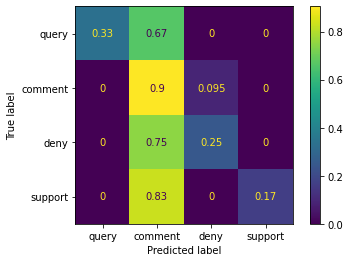

In [85]:
name = 'models/BERT_base_2Input_4layer02'
checkpoint = './drive/My Drive/training_checkpoints'
checkpoint_filepath =  os.path.join(checkpoint,name,"checkpoint_08")
BERT_BASE_4layer_02.load_weights(checkpoint_filepath)
performance_class(BERT_BASE_4layer_02,[x_source_np_real,x_test_np_real],test_y_realtweet, ["query","comment","deny","support"] )